# Satellite Images for Road Segmentation
Dataset: https://www.kaggle.com/datasets/sanadalali/satellite-images-for-road-segmentation

## Download kaggle dataset

In [3]:
import kagglehub
from tqdm import tqdm

# Download latest version
path = kagglehub.dataset_download("sanadalali/satellite-images-for-road-segmentation")

print("Path to dataset files:", path)
%store path

Path to dataset files: /kaggle/input/satellite-images-for-road-segmentation
Stored 'path' (str)


In [4]:
%store -r path
!mv $path .

mv: cannot remove '/kaggle/input/satellite-images-for-road-segmentation/test_set_images/test_37/test_37.png': Read-only file system
mv: cannot remove '/kaggle/input/satellite-images-for-road-segmentation/test_set_images/test_44/test_44.png': Read-only file system
mv: cannot remove '/kaggle/input/satellite-images-for-road-segmentation/test_set_images/test_46/test_46.png': Read-only file system
mv: cannot remove '/kaggle/input/satellite-images-for-road-segmentation/test_set_images/test_43/test_43.png': Read-only file system
mv: cannot remove '/kaggle/input/satellite-images-for-road-segmentation/test_set_images/test_22/test_22.png': Read-only file system
mv: cannot remove '/kaggle/input/satellite-images-for-road-segmentation/test_set_images/test_50/test_50.png': Read-only file system
mv: cannot remove '/kaggle/input/satellite-images-for-road-segmentation/test_set_images/test_45/test_45.png': Read-only file system
mv: cannot remove '/kaggle/input/satellite-images-for-road-segmentation/test

## Dataset exploration

In [5]:
import os
import random
import tensorflow as tf
import keras
import cv2
import matplotlib.pyplot as plt
import numpy as np

PATH = "./satellite-images-for-road-segmentation/"
HEIGHT = 256
WIDTH = 256
NUM_CLASSES = 1
KERNEL_SIZE = 5

In [6]:
# Utility functions to explore the dataset

def read_random_image_and_mask(image_dir, mask_dir):
  image_files = os.listdir(image_dir)
  random_img = random.choice(image_files)
  image_path = os.path.join(image_dir, random_img)
  mask_path = os.path.join(mask_dir, random_img)

  image = cv2.imread(image_path)
  mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
  image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  return image_rgb, mask

def overlay_mask(image, mask, alpha=0.7):
  color_mask = cv2.merge([mask, mask*0, mask*0])
  color_mask_rgb = cv2.cvtColor(color_mask, cv2.COLOR_BGR2RGB)
  return cv2.addWeighted(image, 1, color_mask_rgb, alpha, 0)

def LoG(image, rgb=True, kernel_size=KERNEL_SIZE):
  if rgb:
    grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  else:
    grayscale = image

  blurred = cv2.GaussianBlur(grayscale, (kernel_size, kernel_size), 0)
  laplacian = cv2.Laplacian(blurred, cv2.CV_64F)
  laplacian_abs = cv2.convertScaleAbs(laplacian)

  return laplacian_abs

In [7]:
# Show random image and its mask
IMAGE_DIR = PATH + "training/images/"
MASK_DIR = PATH + "training/groundtruth/"

image_rgb, mask = read_random_image_and_mask(IMAGE_DIR, MASK_DIR)

# Overlay mask over the image
overlay = overlay_mask(image_rgb, mask)

# Try a LoG edge detector
laplacian_abs = LoG(image_rgb)

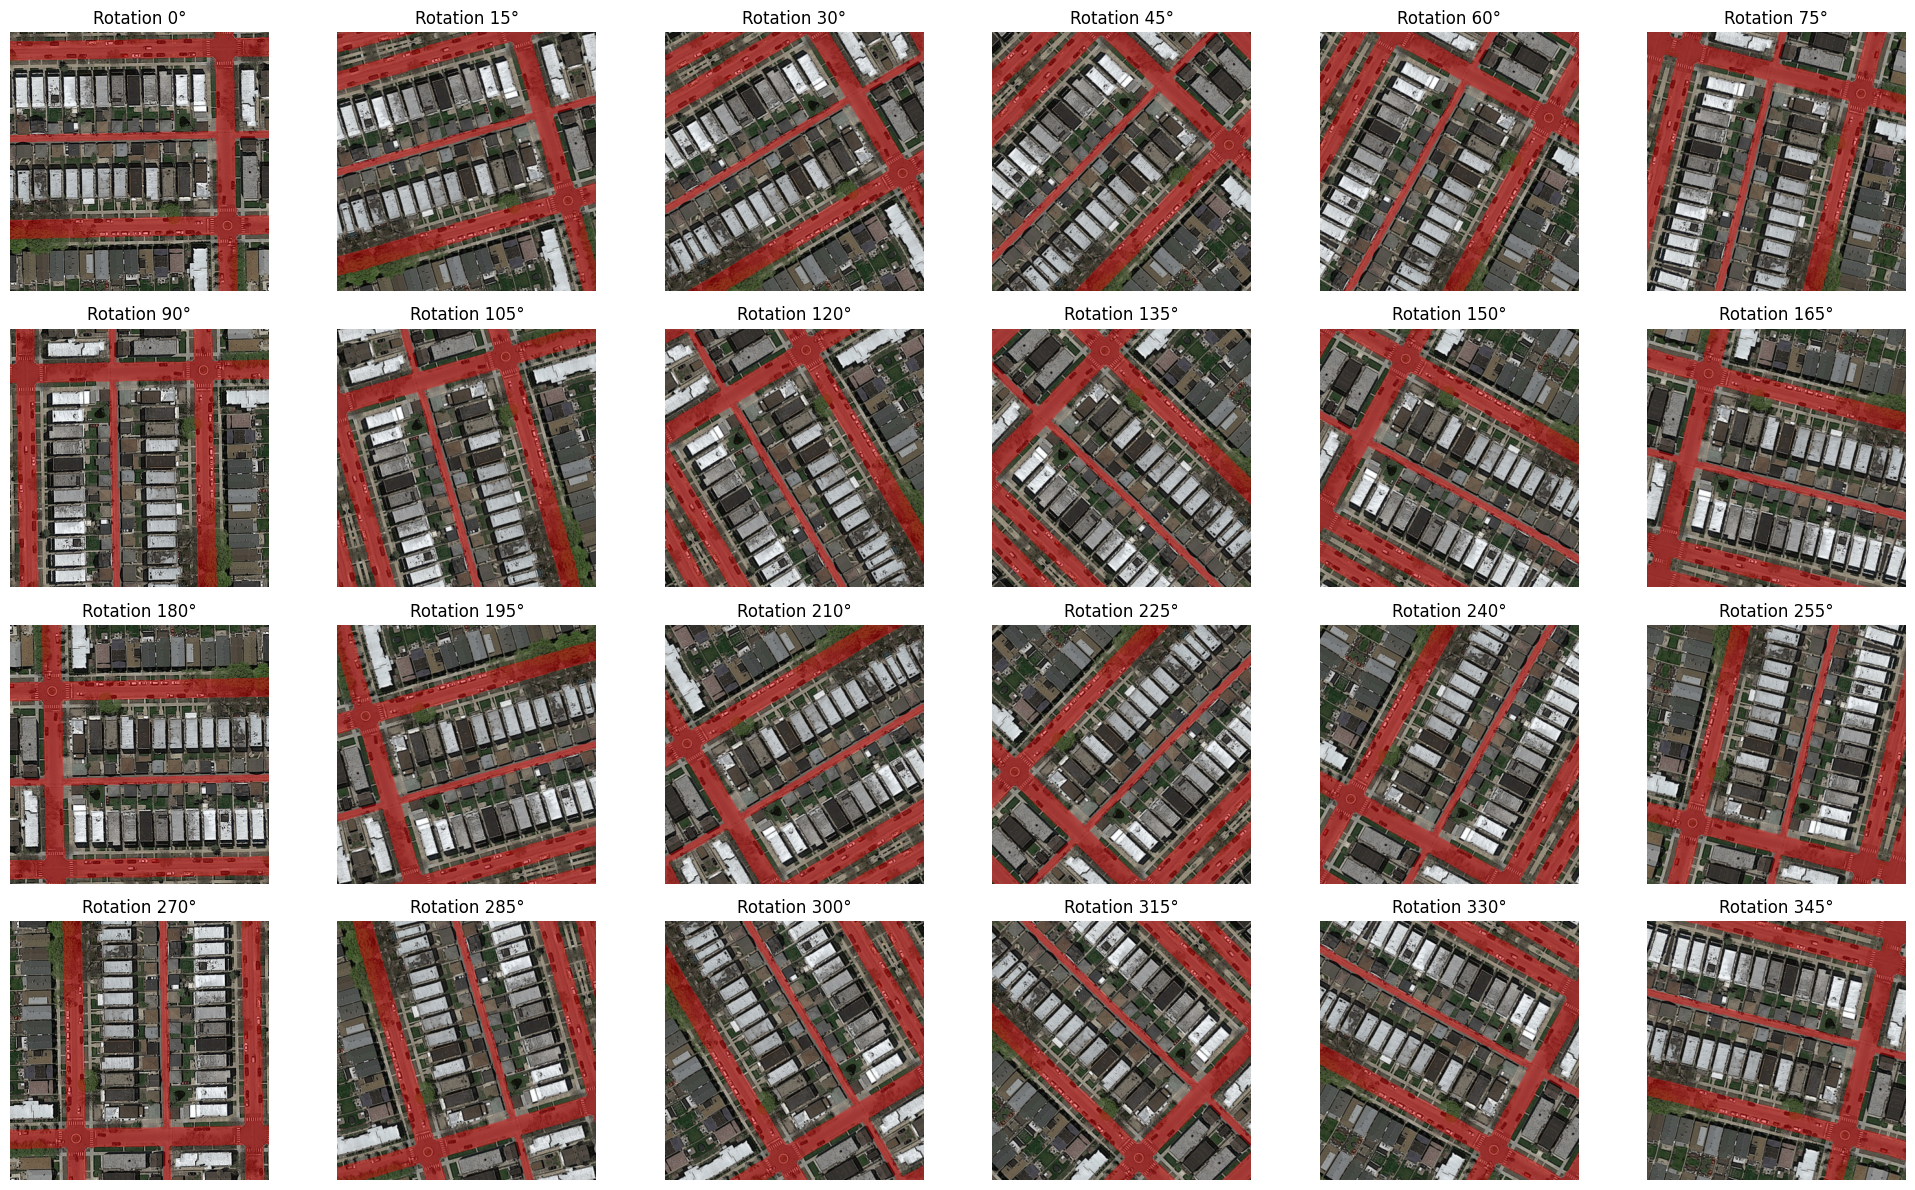

In [8]:
# Rotate function
def rotate_image(image, angle, is_mask=False):
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    interpolation = cv2.INTER_NEAREST if is_mask else cv2.INTER_LINEAR
    rotated = cv2.warpAffine(image, matrix, (w, h), flags=interpolation, borderMode=cv2.BORDER_REFLECT)
    return rotated

# Overlay function
def overlay_mask(image, mask, color=(255, 0, 0), alpha=0.4):
    """Overlay a mask on an image with a given color and transparency."""
    overlay = image.copy()
    mask_rgb = np.zeros_like(image)
    mask_rgb[:, :] = color
    mask_area = mask > 127  # Assuming binary mask with 0 and 255
    overlay[mask_area] = cv2.addWeighted(image, 1 - alpha, mask_rgb, alpha, 0)[mask_area]
    return overlay

# Plot all rotations
angles = list(range(0, 360, 15))
n_cols = 6
n_rows = int(np.ceil(len(angles) / n_cols))

fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 3))
axs = axs.flatten()

for idx, angle in enumerate(angles):
    rotated_img = rotate_image(image_rgb, angle)
    rotated_mask = rotate_image(mask, angle, is_mask=True)

    overlay = overlay_mask(rotated_img, rotated_mask, color=(255, 0, 0), alpha=0.4)

    axs[idx].imshow(overlay)
    axs[idx].set_title(f"Rotation {angle}°")
    axs[idx].axis('off')

# Hide any extra axes
for i in range(len(angles), len(axs)):
    axs[i].axis('off')

plt.tight_layout()
plt.show()

In [9]:
##TO-check

AUG_IMAGE_DIR = os.path.join(PATH, "training_augmented/images/")
AUG_MASK_DIR = os.path.join(PATH, "training_augmented/groundtruth/")
os.makedirs(AUG_IMAGE_DIR, exist_ok=True)
os.makedirs(AUG_MASK_DIR, exist_ok=True)

# Rotate function
def rotate_image(image, angle, is_mask=False):
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    interpolation = cv2.INTER_NEAREST if is_mask else cv2.INTER_LINEAR
    rotated = cv2.warpAffine(image, matrix, (w, h), flags=interpolation, borderMode=cv2.BORDER_REFLECT)
    return rotated

# Process all images
image_files = [f for f in os.listdir(IMAGE_DIR) if f.endswith(('.png', '.jpg', '.jpeg'))]

for filename in tqdm(image_files, desc="Augmenting dataset"):
    image_path = os.path.join(IMAGE_DIR, filename)
    mask_path = os.path.join(MASK_DIR, filename)

    # Read images
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Save original
    base_filename = os.path.splitext(filename)[0]
    cv2.imwrite(os.path.join(AUG_IMAGE_DIR, base_filename + '_rot0.png'), cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
    cv2.imwrite(os.path.join(AUG_MASK_DIR, base_filename + '_rot0.png'), mask)

    # Rotate every 15 degrees
    for angle in range(15, 360, 15):
        rotated_image = rotate_image(image, angle)
        rotated_mask = rotate_image(mask, angle, is_mask=True)

        new_image_filename = f"{base_filename}_rot{angle}.png"
        new_mask_filename = f"{base_filename}_rot{angle}.png"

        cv2.imwrite(os.path.join(AUG_IMAGE_DIR, new_image_filename), cv2.cvtColor(rotated_image, cv2.COLOR_RGB2BGR))
        cv2.imwrite(os.path.join(AUG_MASK_DIR, new_mask_filename), rotated_mask)

print("Augmented dataset saved locally!")

Augmenting dataset: 100%|██████████| 100/100 [00:36<00:00,  2.71it/s]

Augmented dataset saved locally!


In [10]:
len([f for f in os.listdir(AUG_IMAGE_DIR) if f.endswith(('.png'))])

2400

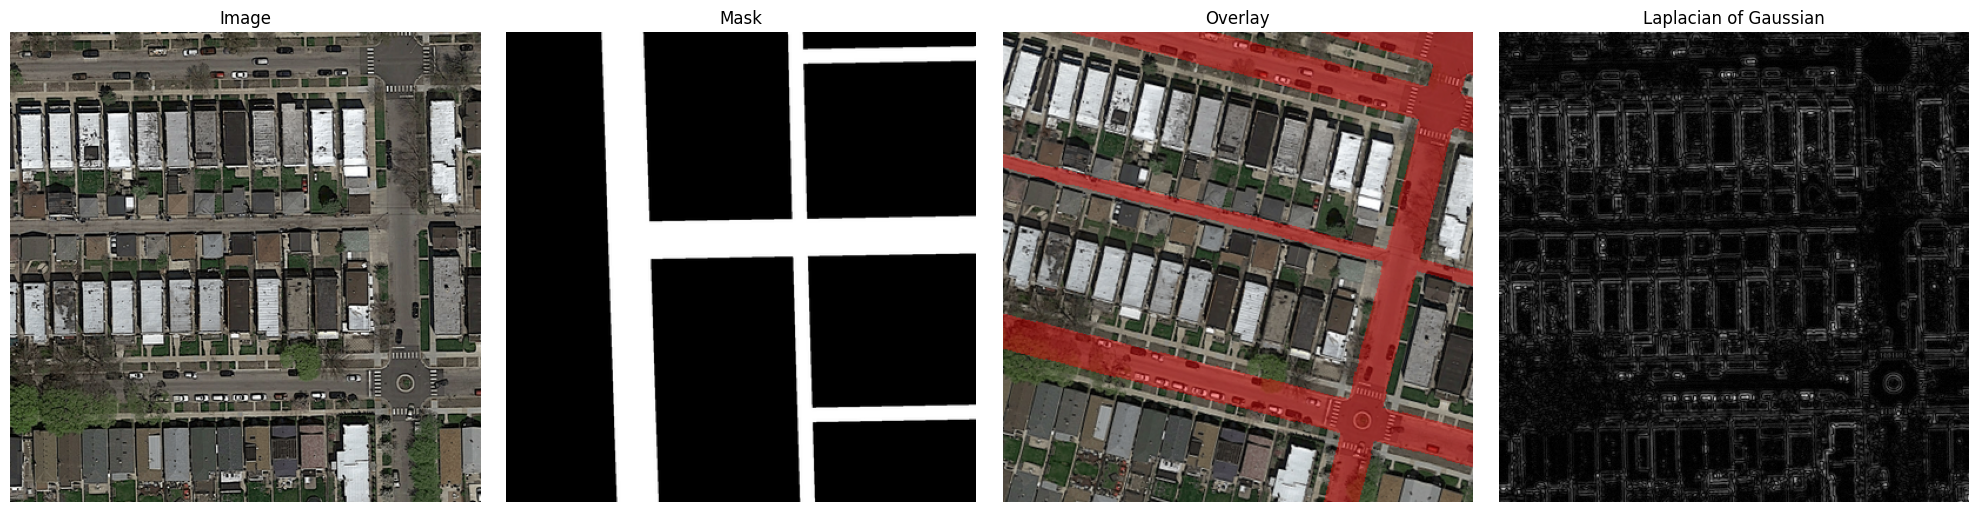

In [11]:
# Display side by side
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
images = [image_rgb, mask, overlay, laplacian_abs]
titles = ["Image", "Mask", "Overlay", "Laplacian of Gaussian"]
cmaps = [None, 'gray', None, 'gray']
for i, (image, title, cmap) in enumerate(zip(images, titles, cmaps)):
    axs[i].imshow(image, cmap=cmap)
    axs[i].set_title(title)
    axs[i].axis('off')

plt.tight_layout()
plt.show()

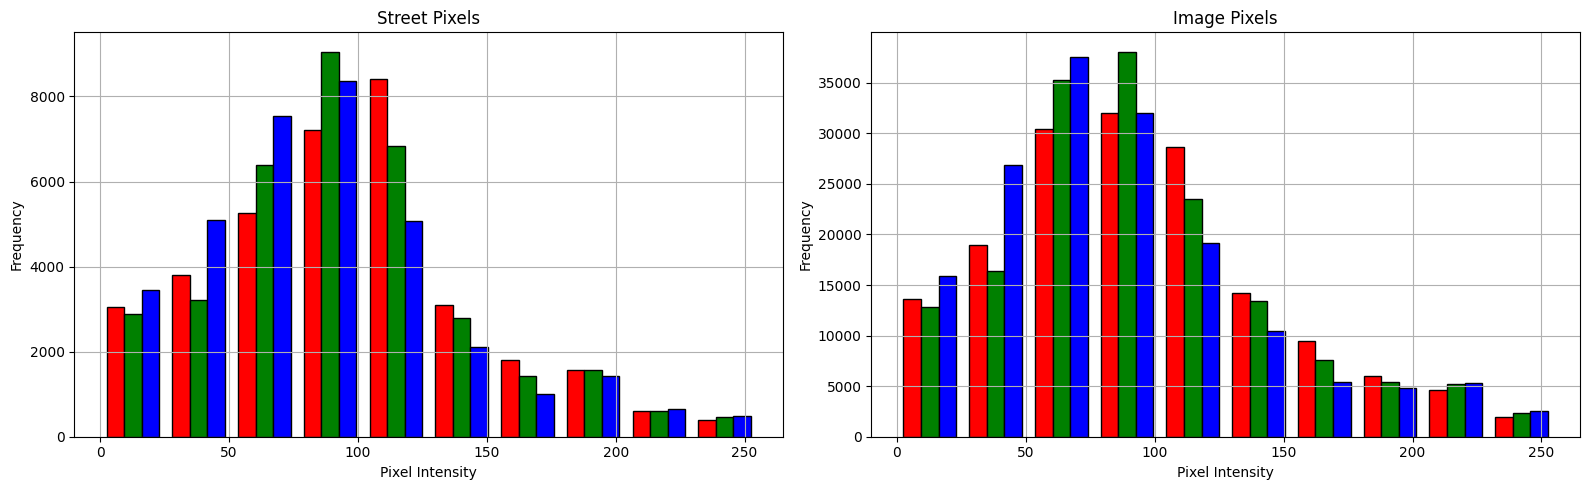

In [12]:
# Show mask street values and the whole image values
street_pixels = image_rgb[mask > 0]
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

images = [street_pixels, image_rgb.reshape(-1, image_rgb.shape[-1])]
titles = ["Street Pixels", "Image Pixels"]
for i, (image, title) in enumerate(zip(images, titles)):
    axs[i].hist(image, color=['red', 'green', 'blue'], edgecolor='black')
    axs[i].set_title(title)
    axs[i].set_xlabel("Pixel Intensity")
    axs[i].set_ylabel("Frequency")
    axs[i].grid(True)

plt.tight_layout()
plt.show()

## First U-net try using the training set without any additional preprocessing

In [13]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate

def down_block(inputs, filters, kernel_size=(3, 3), padding='same', activation='relu'):
    conv = Conv2D(filters, kernel_size, activation=activation, padding=padding)(inputs)
    conv = Conv2D(filters, kernel_size, activation=activation, padding=padding)(conv)
    pool = MaxPooling2D(pool_size=(2, 2))(conv)
    return conv, pool

def up_block(inputs, skip, filters, kernel_size=(3, 3), padding='same', activation='relu'):
    up = UpSampling2D(size=(2, 2))(inputs)
    concat = Concatenate()([up, skip])
    conv = Conv2D(filters, kernel_size, activation=activation, padding=padding)(concat)
    conv = Conv2D(filters, kernel_size, activation=activation, padding=padding)(conv)
    return conv


def unet(img_size=(HEIGHT, WIDTH), num_classes=1, num_channels=3):
    inputs = Input(shape=img_size + (num_channels,))

    #Down Blocks
    conv1, pool1 = down_block(inputs, 64)
    conv2, pool2 = down_block(pool1, 128)
    conv3, pool3 = down_block(pool2, 256)

    # Bottleneck
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)

    #Up Blocks
    conv5 = up_block(conv4, conv3, 256)
    conv6 = up_block(conv5, conv2, 128)
    conv7 = up_block(conv6, conv1, 64)

    # Add a per-pixel classification layer
    outputs = Conv2D(num_classes, 3, activation="sigmoid", padding="same")(conv7)

    model = Model(inputs=inputs, outputs=outputs, name="unet")
    return model


# Build model
NUM_CHANNELS = 3
model = unet(img_size=(HEIGHT, WIDTH), num_classes=NUM_CLASSES)

if tf.test.gpu_device_name():
    print('TensorFlow is using GPU/TPU')
else:
    print('TensorFlow is using CPU')

TensorFlow is using GPU/TPU


In [15]:
model.summary()

Model: "unet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 64, 64,    │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 768)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 64, 64,    │  1,769,728 │ concatenate[0][0] │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_8[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 128, 128,  │          0 │ conv2d_9[0][0]  

 Total params: 7,783,425 (29.69 MB)

 Trainable params: 7,783,425 (29.69 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Scale image and set mask to 1
def rescale_image_reset_mask(input):
    image, mask = input
    image_normalized = tf.cast(image, tf.float32) / 255.0

    if mask is None:
      return (image_normalized, None)

    hard_mask = np.where(mask > 0, 1, 0)
    return (image_normalized, hard_mask)

def read_image_mask(image_path, mask_path, image_name, with_mask=True):
    image = cv2.imread(os.path.join(image_path, image_name))
    image = cv2.resize(image, (WIDTH, HEIGHT))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    if with_mask:
      mask = cv2.imread(os.path.join(mask_path, image_name), cv2.IMREAD_GRAYSCALE)
      mask = cv2.resize(mask, (WIDTH, HEIGHT))
      return rescale_image_reset_mask((image, mask))
    return rescale_image_reset_mask((image, None))

# Create training set adding or ignoring the generated images
def create_train_test(path, shape=(HEIGHT, WIDTH), generated=False, num_img_generated=200):
  height, width = shape
  X_train_dir = path + "/training/images/"
  Y_train_dir = path + "/training/groundtruth/"
  X_test_dir = path + "/test_set_images/"
  image_files = os.listdir(X_train_dir)
  not_generated_len = len(image_files)
  random.shuffle(image_files)

  if generated:
    X_train_gen_dir = path + "/training/images_generated/"
    Y_train_gen_dir = path + "/training/groundtruth_generated/"
    image_files_gen = os.listdir(X_train_gen_dir)
    random.shuffle(image_files_gen)
    image_files_gen = image_files_gen[:num_img_generated]
    image_files += image_files_gen
    X_train = np.zeros((len(image_files), height, width, NUM_CHANNELS))
    Y_train = np.zeros((len(image_files), height, width))
    for i, image_file in enumerate(image_files[not_generated_len:]):
      image, mask = read_image_mask(X_train_gen_dir, Y_train_gen_dir, image_file)
      X_train[i + not_generated_len, :, :, :] = image
      Y_train[i + not_generated_len, :, :] = mask
  else:
    X_train = np.zeros((len(image_files), height, width, NUM_CHANNELS))
    Y_train = np.zeros((len(image_files), height, width))

  for i, image_file in enumerate(image_files[:not_generated_len]):
    image, mask = read_image_mask(X_train_dir, Y_train_dir, image_file)
    X_train[i, :, :, :] = image
    Y_train[i, :, :] = mask

  test_folders = os.listdir(X_test_dir)
  X_test = np.zeros((len(test_folders), height, width, NUM_CHANNELS))
  for i, folder in enumerate(test_folders):
    image_path = os.path.join(X_test_dir, folder)
    image, _ = read_image_mask(image_path, None, os.listdir(image_path)[0], with_mask=False)
    X_test[i, :, :, :] = image

  return X_train, Y_train, X_test

X_train, Y_train, X_test = create_train_test(PATH)
Y_train = np.expand_dims(Y_train, axis=-1)

In [16]:
# BinaryCrossEntropy + Dice loss
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice

def dice_loss(y_true, y_pred, smooth=1e-6):
    return 1 - dice_coefficient(y_true, y_pred, smooth)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    dsc = dice_loss(y_true, y_pred)
    return bce + dsc

In [17]:
def parse_image(image_path, mask_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)  # Normalize to [0, 1]

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.convert_image_dtype(mask, tf.float32)  # Normalize to [0, 1]

    return image, mask


In [18]:
from sklearn.model_selection import train_test_split

def data_generator(img_paths, mask_paths):
    for img, mask in zip(img_paths, mask_paths):
        yield img, mask

EPOCHS = 5
BATCH_SIZE = 16
LEARNING_RATE = 1e-3

image_paths = sorted([os.path.join(AUG_IMAGE_DIR, f) for f in os.listdir(AUG_IMAGE_DIR) if f.endswith('.png')])
mask_paths = sorted([os.path.join(AUG_MASK_DIR, f) for f in os.listdir(AUG_MASK_DIR) if f.endswith('.png')])

train_imgs, val_imgs, train_masks, val_masks = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=42
)

train_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(train_imgs, train_masks),
    output_signature=(
        tf.TensorSpec(shape=(), dtype=tf.string),
        tf.TensorSpec(shape=(), dtype=tf.string)
    )
)

val_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(val_imgs, val_masks),
    output_signature=(
        tf.TensorSpec(shape=(), dtype=tf.string),
        tf.TensorSpec(shape=(), dtype=tf.string)
    )
)

train_dataset = train_dataset.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(100).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE).repeat()

val_dataset = val_dataset.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE).repeat()

In [21]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=bce_dice_loss,           # or 'binary_crossentropy' if simpler
    metrics=[dice_coefficient]    # or just ['accuracy'] if simpler
)

In [22]:
steps_per_epoch = len(train_imgs) // BATCH_SIZE
validation_steps = len(val_imgs) // BATCH_SIZE

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps
)

Epoch 1/5
120/120 ━━━━━━━━━━━━━━━━━━━━ 389s 2s/step - dice_coefficient: 0.2374 - loss: 1.6802 - val_dice_coefficient: 0.3203 - val_loss: 1.1168
Epoch 2/5
120/120 ━━━━━━━━━━━━━━━━━━━━ 218s 2s/step - dice_coefficient: 0.3059 - loss: 1.1597 - val_dice_coefficient: 0.3195 - val_loss: 1.1104
Epoch 3/5
120/120 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - dice_coefficient: 0.3421 - loss: 1.0888 - val_dice_coefficient: 0.4303 - val_loss: 0.9412
Epoch 4/5
120/120 ━━━━━━━━━━━━━━━━━━━━ 213s 2s/step - dice_coefficient: 0.3930 - loss: 1.0292 - val_dice_coefficient: 0.4046 - val_loss: 0.9518
Epoch 5/5
120/120 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - dice_coefficient: 0.5129 - loss: 0.8300 - val_dice_coefficient: 0.6385 - val_loss: 0.6561


In [ ]:
Y_pred = model.predict(X_train)
Y_test = model.predict(X_test)

In [ ]:
from sklearn.metrics import jaccard_score

def evaluate_threshold(y_true, y_pred, thresholds):
    scores = np.zeros_like(thresholds)
    y_true_flat = y_true.reshape(-1)
    y_pred_flat = y_pred.reshape(-1)

    for i, thresh in enumerate(thresholds):
      y_pred_bin = (y_pred_flat > thresh).astype(np.uint8)
      scores[i] = jaccard_score(y_true_flat, y_pred_bin)

    return scores

thresholds = np.linspace(0.1, 0.9, 41)

scores = evaluate_threshold(Y_train, Y_pred, thresholds)

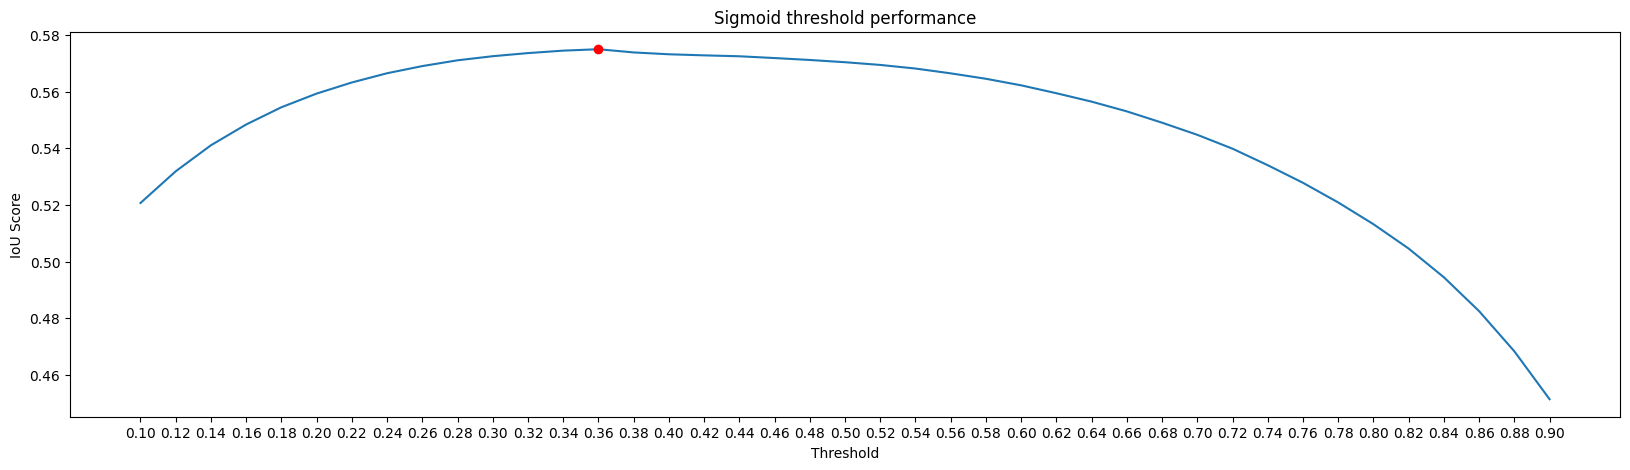

In [ ]:
index = np.argmax(scores)
THRESHOLD, max_score = thresholds[index], scores[index]

plt.figure(figsize=(20, 5))
plt.plot(thresholds, scores)
plt.plot(THRESHOLD, max_score, 'ro')
plt.xlabel('Threshold')
plt.xticks(thresholds)
plt.ylabel('IoU Score')
plt.title('Sigmoid threshold performance')
plt.show()

In [ ]:
def postprocessing(test_images, masks, threshold):
  test_images = tf.cast(test_images * 255, tf.uint8)
  masks = np.where(masks > threshold, 1, 0) * 255
  return test_images, masks

def show_test_images(test, masks, num_samples=4):
  samples = random.sample(range(len(test)), num_samples)
  fig, axes = plt.subplots(num_samples, 2, figsize=(10, 5 * num_samples))
  for i, sample in enumerate(samples):
    axes[i, 0].imshow(test[sample][:, :, :3])
    axes[i, 0].set_title(f"Satellite Image {i+1}")
    axes[i, 0].axis('off')
    axes[i, 1].imshow(masks[sample], cmap="gray")
    axes[i, 1].set_title(f"Predicted mask {i+1}")
    axes[i, 1].axis('off')
  plt.tight_layout()
  plt.show()

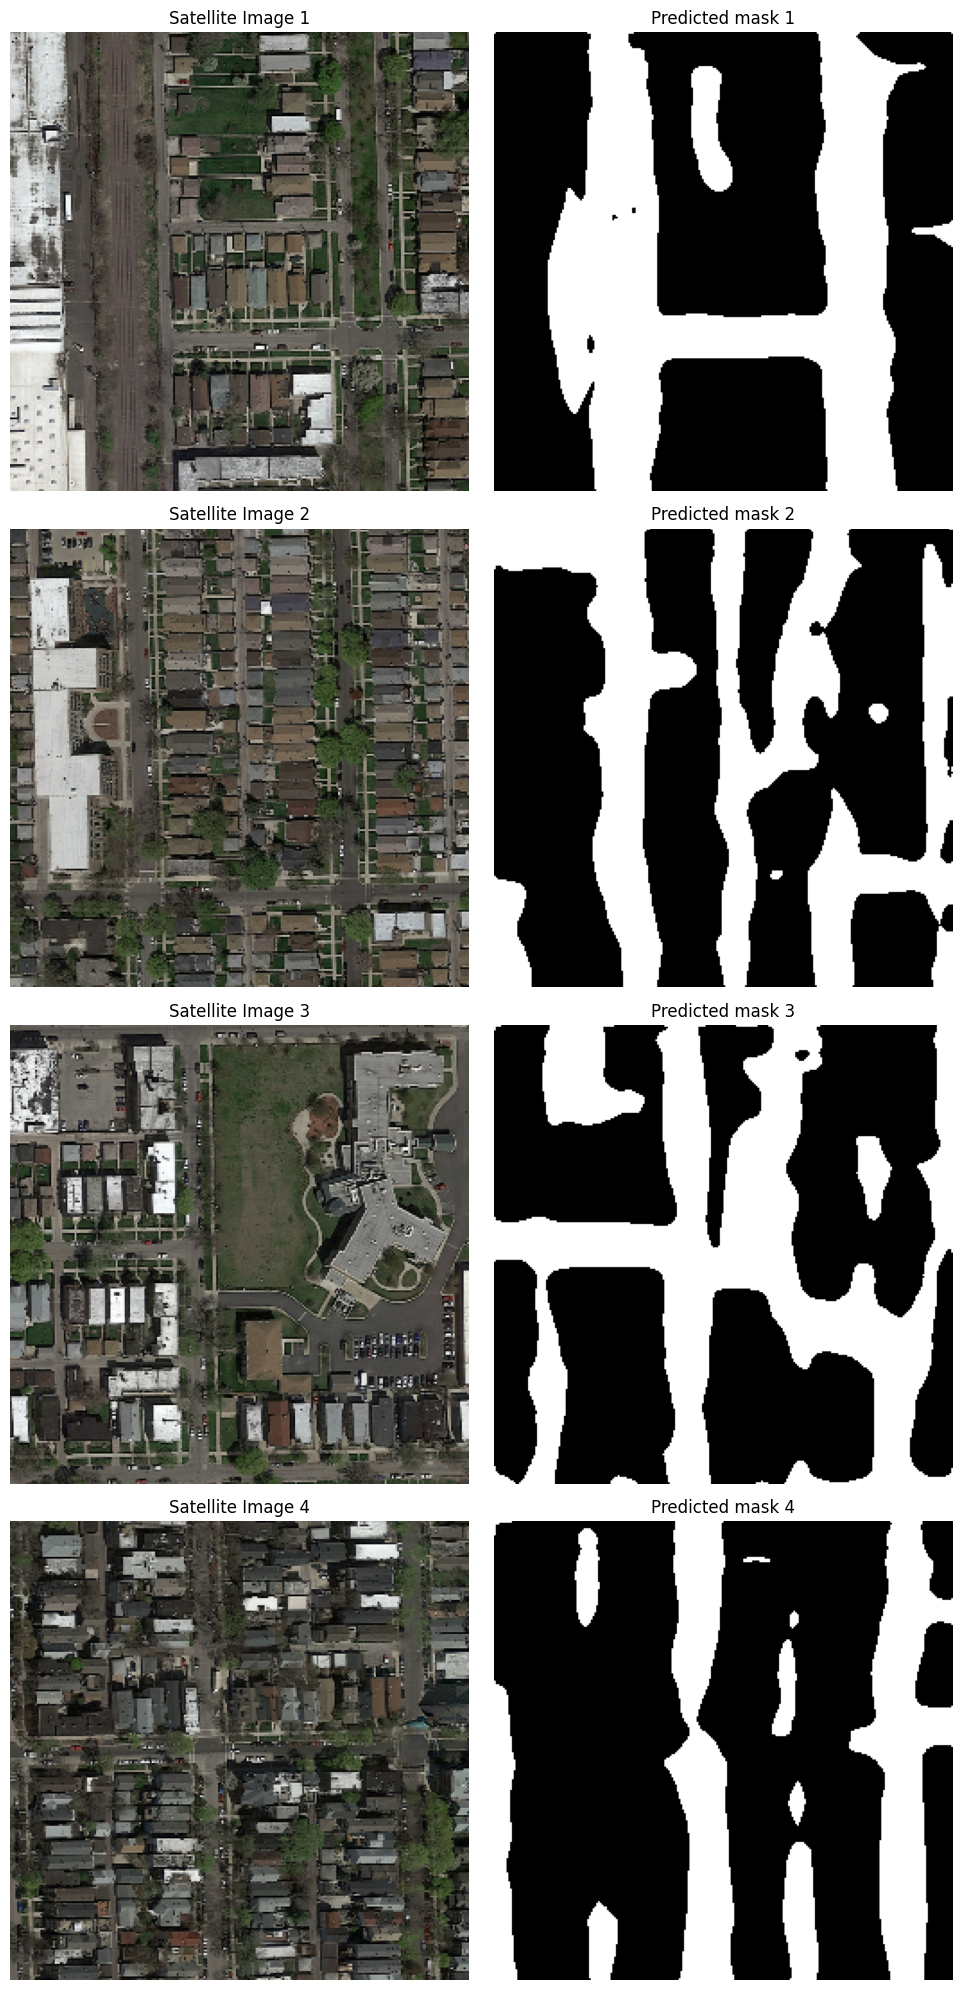

In [ ]:
show_test_images(*postprocessing(X_test, Y_test, THRESHOLD))

## Same configuration but adding in the training set artificial generated satellite images

In [ ]:
# First, define a complete postprocessing function
def plot_threshold_scores(threshold, scores):
  plt.figure(figsize=(20, 5))
  plt.plot(thresholds, scores, label='IoU Score')
  plt.xlabel('Threshold')
  plt.xticks(thresholds)
  plt.ylabel('Score')
  plt.legend()
  plt.title('Threshold Performance')
  plt.show()

def full_postprocessing_test(model, X_train, Y_train, X_test, thresholds):
  Y_pred = model.predict(X_train)
  Y_test = model.predict(X_test)
  scores = evaluate_threshold(Y_train, Y_pred, thresholds)
  plot_threshold_scores(thresholds, scores)
  THRESHOLD = thresholds[np.argmax(scores)]
  show_test_images(*postprocessing(X_test, Y_test, THRESHOLD))

In [ ]:
X_train, Y_train, X_test = create_train_test(".", generated=True)
Y_train = np.expand_dims(Y_train, axis=-1)
X_train.shape, Y_train.shape

In [ ]:
model = unet(img_size=(HEIGHT, WIDTH), num_classes=NUM_CLASSES)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=bce_dice_loss,
    metrics=[dice_coefficient]
)

In [ ]:
BATCH_SIZE = 16

history = model.fit(
    X_train,
    Y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.2
)

In [ ]:
full_postprocessing_test(model, X_train, Y_train, X_test, thresholds)

TODO

Ruotare iimmagini e mask

Nuovo dataset

Un possibile 4th canale con la probabilità di appartenere alla gaussiana